# XL741/741SE Simulation and Experiments

By Shuo Chen (chenshuo_at_chenshuo.com) [70% done]

Latest version: https://chenshuo.github.io/notes/XL741/

Jupyter source of this page: https://github.com/chenshuo/notes/blob/master/notebooks/XL741.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

In [1]:
%matplotlib inline

from math import exp, log, log10

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-6:
            print('%10s = %8.2f uA' % (k, 1e6*current))
        else:
            print('%10s = %8.2f nanoA' % (k, 1e9*current))
    else:
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 1.5:
            print('%10s = %8.3f V' % (k, voltage))
        else:
            print('%10s = %8.2f mV' % (k, 1e3*voltage))

In [2]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

David Fullagar invented the μA741 op-amp integrated circuit in 1968, while working for Fairchild.
https://spectrum.ieee.org/chip-hall-of-fame-fairchild-semiconductor-a741-opamp

[XL741](https://shop.evilmadscientist.com/productsmenu/762) and [741SE](https://shop.evilmadscientist.com/productsmenu/923) are
faithful and functional transistor-scale replicas of the μA741 IC, designed by [Eric Schlaepfer](http://tubetime.us/), in collaboration with [Evil Mad Scientist Laboratories](https://www.evilmadscientist.com/). Here's [the central documentation site](https://wiki.evilmadscientist.com/741) for these discrete 741 Op-Amp kits.

IMO, new designs in the 21th century [should not use μA741](https://electronics.stackexchange.com/questions/304521/reasons-not-to-use-a-741-op-amp), there are better alternatives, so called ["jelly-bean op-amps"](https://www.youtube.com/watch?v=uq1DMWtjL2U&ab_channel=EEVblog).
As per https://electronics.stackexchange.com/a/8257

> It's an ideal op amp to learn the basics on due to its non-ideal nature.

This 55-year old design has large input offset voltage (~1mV), large bias current (80nA), large supply current (1.7mA), low bandwidth (1MHz) and low slew rate (0.5V/μV).

## Schematic

### A bit of datasheet archaeology

AFAIK, there are three common variants of µA741:

* Fairchild's original 20-transistor µA741/µA741C, as seen in [1970 datasheet](fairchild1970.pdf). This is probably David Fullagar's original design.
* Fairchild's improved 24-transistor µA741A/µA741E, first seen in  [1973 datasheet](fairchild1973a.pdf), interestingly, the [1973 databook](fairchild1973.pdf) also lists µA741/µA741C, right before µA741A datasheets. 
Years later, in [1979 databook](fairchild1979.pdf), only 24-transistor '741 survived and named just 'µA741'.
* TI's 22-transistor [uA741](ti1984.pdf), but the datasheet doesn't label the transistors or resistor values.

> Databooks are taken from <http://www.bitsavers.org/components/fairchild/_dataBooks/>

My wild guess: Fairchild improved their fabrication in 1972/1973, and tweaked original 20T µA741 to make the 24T µA741A.
David Fullagar joined Intersil in 1969, so the 24T design must have been done by his former colleagues in Fairchild.

One evidence: the typical input bias current (average base currents of Q1/Q2) reduced from 80nA to 30nA, if the collector currents of Q1/Q2 kept the same (around 9.5µA per transistor per calculation below), we could infer that the $\beta$ of NPN transistors improved from $9.5 / 0.08 \approx 120$ to $9.5 / 0.03 \approx 317$.

Another evidence of increasing $\beta$: In the original 20T design, Q16 and Q17 form a Darlinton pair for the gain stage. In new 24T design, Q16 becomes a emitter follower, and the gain is mainly provided by Q17 and its active load Q13B solely.

History of Op-Amp:

* https://www.analog.com/media/en/training-seminars/design-handbooks/Op-Amp-Applications/SectionH.pdf
* https://www.mikrocontroller.net/attachment/172187/History18opamp.pdf
* https://sound-au.com/articles/opamp-history.htm
* https://web.physics.utah.edu/~jui/3620-6620/y2009m02d03/741.html
* https://spectrum.ieee.org/chip-hall-of-fame-fairchild-semiconductor-a741-opamp

### Full and simplified schematic

The XL741/741SE kits employ the original 20-transistor schematic, probably because the double collector PNP transistor Q13 in the 24-transistor design is not available as discrete components.

Here's the full schematic of XL741/741SE, with simulated DC operating points. Q15/Q22 are drawn in dashed lines, because they are off in normal conditions.

![](xl741op.png)

[741: Principles of Operation](https://cdn.evilmadscientist.com/KitInstrux/741/741_principles_Rev21.pdf) explains this circuit in great details.

A few notes:

* There's no Q19 or Q21, so the total transistor count is 20, despite that there's a Q22 in the schematic.
 Similarly, there's no R6. It's not a mistake, but faithfully conforms to the [original 1970 datasheet](fairchild1970.pdf).
* Looking at the [original 1970 datasheet](fairchild1970.pdf), there seems to be too much space between the 2nd stage (Q17 and its active load Q13) and the output stage (Q14/Q20). It might suggest there were revisions of circuits before the released on datasheet.
* Based on simulation results, the systematic error of input offset voltage ~0.57mV, even with perfectly matched transistors.
* In the µA741 chip, the area of output transistor is supposed to be 3x of normal transistors (larger Is, therefore larger Ie for the same Vbe), but in XL741, all transistor are the same, so the bias currents of Q14 and Q20 might be smaller than intended values. We can adjusting R7 to maybe 5.1k or even higher to accommodate that.

Here's a simplified schematic showing the essential signal paths:

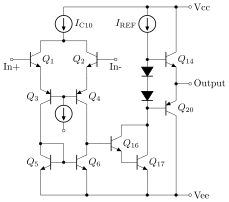

In [3]:
%%tikz -p circuitikz -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

% Q1 Q2 Q3 Q4
\draw (0,0) node [below] {In+}
  to [short, o-] ++(0.3, 0)
  node [npn, anchor=B] (Q1) {$Q_1$};
\draw (Q1.E) node [pnp, anchor=E, xscale=-1] (Q3) {\ctikzflipx{$Q_3$}};
\draw (Q3.B) to [short] ++(0.2, 0)
  node [pnp, anchor=B] (Q4) {$Q_4$};
\draw (Q4.E) node [npn, anchor=E, xscale=-1] (Q2) {\ctikzflipx{$Q_2$}};
\draw (Q2.B) to [short, -o] ++(0.3, 0) node [below] {In-};
\draw (Q1.C) -- (Q2.C);
\draw (Q1.C -| Q3.B) ++(0.1, 0) coordinate (I1) node [circ] {}
  to [I, invert, bipoles/length=1.0cm, l_={$I_\mathrm{C10}$}] ++(0, 1.2) coordinate (VCC);
\draw (Q3.B -| I1) node [circ] {} to [I,  bipoles/length=1.0cm] ++(0, -1.2) node [ocirc] {};

% Q5 Q6 Q7
\draw (Q3.C) to [short] ++(0, -1)
  node [npn, anchor=C, xscale=-1] (Q5) {\ctikzflipx{$Q_5$}};
%\draw (Q5.E) to [R, l2={$R_1$ and 1k}, bipoles/length=1.0cm] ++(0, -1.5) coordinate (G);
\draw (Q5.E) to [short] ++(0, -0.5) coordinate (G);
\draw (Q4 |- Q5) node [npn] (Q6) {$Q_6$};
\draw (Q6.E) to [short, -*] (Q6.E|-G);
%\draw (Q6.E) to [R, l2={$R_2$ and 1k}, bipoles/length=1.0cm] (Q6.E|-G) node [circ] {};
\draw (Q5.B) -- (Q6.B);
\draw (Q6.C) -- (Q4.C);
\draw (Q5.B -| I1) node [circ] {} |- (Q5.C) node [circ] {};

% Q16 Q17
\draw (Q6.C) to [short, *-] ++(0.5, 0) node [npn, anchor=B] (Q16) {$Q_{16}$};
\draw (Q16.E) to [short] ++(0.2, 0) node [npn, anchor=B] (Q17) {$Q_{17}$};
\draw (Q16.C) to [short, -*] (Q16.C -| Q17.C);
\draw (Q17.E) to [short, -*] (Q17.E|-G);

% Q14 Q20
\draw (VCC -| Q17.C) node [circ] {} to [I, l_={$I_\mathrm{REF}$}, bipoles/length=1.0cm] (I1-|Q17.C)
  to (Q2.B-|Q17.C) to [short,, *-] ++(0.3, 0) node [npn, anchor=B] (Q14) {$Q_{14}$};
\draw (Q14.E) to [short] ++(0, -0.2) coordinate (OUT)
  to [short] ++(0, -0.2) node [pnp, anchor=E] (Q20) {$Q_{20}$};
\draw (Q20.B) to [short, -*] (Q20.B-|Q17.C);
\draw (OUT) to [short, *-o] ++(0.5, 0) node [right] {Output};
\draw (Q14.B-|Q17.C) to [D*, bipoles/length=0.8cm] (OUT-|Q17.C)
  to [D*, bipoles/length=0.8cm] (Q20.B-|Q17.C) -- (Q17.C);

\draw (Q14.C) to [short, -*] (Q14.C|-VCC) -- (VCC);
\draw (Q14.C|-VCC) to [short, -o] ++(0.5, 0) node [right] {Vcc};

\draw (Q20.C) to [short, -*] (Q20.C|-G) -- (G);
\draw (Q20.C|-G) to [short, -o] ++(0.5, 0) node [right] {Vee};

It's a fairly typical 3-stage opamp design from today's perspective,

## DC Analysis

The analysis and calculation in this section closely follows
Chapter 12 of _Sedra & Smith 6e_, which I keep on my desktop.
The same content is now available for download from
[Supplement x4](https://learninglink.oup.com/access/sedra8e-student-resources#tag_bonus-text-topics) of [_Microelectronic Circuits 8e_](https://learninglink.oup.com/access/sedra8e)

FIXME: Paul Gray'e 4th edition

It's worth note that these two books analyze the 24-transistor variant of 741, while XL741/741SE are the 20-transistor variant. According to Ken Shirriff in [Understanding silicon circuits: inside the ubiquitous 741 op amp](https://www.righto.com/2015/10/inside-ubiquitous-741-op-amp-circuits.html#ref11), the 24-transistor variant is more common though.

### Transistor parameters

XL741 is built with discrete 2N3904 (NPN) and 2N3906 (PNP) transistors, although their SPICE models can be found from manufacturer's datasheets, 
Dr. Kent H. Lundberg says these models are "worthless" and suggests not to use them in simulations. <https://www.mit.edu/~6.301/>. I agree with him, because the model parameters disagree with my measurement. In particular, while the Vaf of PNP is only 18.7V, which is too low to be true. Another source https://physics.uncg.edu/hellen/spice_stuff.html
$\newcommand{\uv}[1]{{V_\mathrm{#1}}} \newcommand{\Vt}{\uv{T}}  \newcommand{\Vbe}{\uv{BE}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}} \newcommand{\Is}{\ui{S}}$
$\newcommand{\mV}{\mathrm{mV}} \newcommand{\mA}{\mathrm{mA}} \newcommand{\uA}{\mathrm{µA}}$

**Measure $\beta$ and $\Is$**


I measured 3 2N3904 (TO-92 packages, not SOT-23 come with my 741SE kits) using multimeters , here's the results:

| Transistor | $\beta$* | Vbe @ Ie=440µA | Vbe @ Ie=1.28mA |
| --- | --- | --- | --- |
| 2N3904 no.1 | 159 | 636mV | 662mV |
| 2N3904 no.2 | 166 | 637mV | 662mV |
| 2N3904 no.3 | 165 | 636mV | 662mV |
| 2N3904 average | 163.3 | 636.3mV | 662.0mV |

\* My cheap [AVR transistor tester](https://www.mikrocontroller.net/articles/AVR_Transistortester) clone from Ebay shows higher $\beta$ values, I am more trusting multimeters.

Recall basic Ebers-Moll model:

$\ui{E} = \Is\exp\dfrac{\uv{BE}}{\Vt}$

If we assume $\Vt=25.8\mathrm{mV}$, we could calculate $\Is = \ui{E}\Big/\exp\dfrac{\uv{BE}}{\Vt}$

In [7]:
Vt = 25.8
Ie1  = 440e-6
Vbe1 = 636.3
Is1 = Ie1 / exp(Vbe1 / Vt)
print('Is1 = %g' % Is1)

Ie2  = 1.28e-3
Vbe2 = 662.0
Is2 = Ie2 / exp(Vbe2 / Vt)
print('Is2 = %g' % Is2)

Is1 = 8.56128e-15
Is2 = 9.19782e-15


For simplicity, I just assume $\Is=10$fA in my calculation and simulation.

Then I did the same on 3 2N3906 transistors, got similar 10fA $\Is$. (9.73fA when Ie = 440uA, 10.7fA whtn Ie = 1.28mA).


**Measure Early voltage $\uv{A}$**

I don't have a curve tracer, instead, using 3 multimeters, I was able to measue the base current, collector current and Vce at the same time. Here's the result of one 2N3906 (PNP).

| Ib (uA) | Ic (mA) | Vce (V) |
| --: | --- | --: |
| 10.19 | 2.275 | 15.97 |
| 10.19 | 2.242 | 14.98 |
|10.17 | 2.209 | 13.97 |
|10.05 | 2.151 | 12.98 |
|10.06 | 2.119 | 11.98 |
|10.06 | 2.094 | 10.97 |
|10.02 | 2.058 | 9.97 |
|10.01 | 2.028 | 8.97 |
|9.99 | 1.992 | 7.98 |
|10.00 | 1.967 | 6.97 |
|9.98 | 1.938 | 5.98 |
|10.06 | 1.928 | 4.98 |
|10.02 | 1.894 | 3.98 |
|9.99 | 1.853 | 2.97 |

> $\beta$ can also be calculated from the data above, it's around 180 for this PNP transistor.

If we ignore the $\ui{B}$ variances, and run a simple linear regression of $\ui{C}$ versus $\uv{CE}$, we got:

Text(0, 0.5, 'Ic @ Ib=10uA')

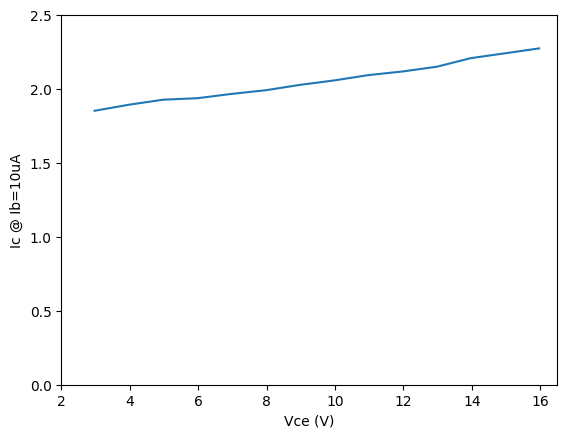

In [12]:
Ic = [2.275, 2.242, 2.209, 2.151, 2.119, 2.094, 2.058, 2.028, 1.992, 1.967, 1.938, 1.928, 1.894, 1.853]
Vce = [15.97, 14.98, 13.97, 12.98, 11.98, 10.97, 9.97, 8.97,7.98,6.97,5.98,4.98,3.98,2.974]

plt.plot(Vce, Ic)
plt.ylim(0, 2.5)
plt.xlim(2, 16.5)
plt.xlabel('Vce (V)')
plt.ylabel('Ic (mA) @ Ib=10uA')

In [17]:
m, b = np.polyfit(Vce, Ic, 1)
print(m, b)
print('Va = %.1f V' % (b/m))

0.031722893069276184 1.7528450959134443
Va = 55.3 V


We will assume Vaf = 50V for PNP transistors.
Similarly, I measure one 2N3904, its Vaf was ~200V.

**Parameters for calculation and simulation**

| Transistor | $\beta$ | $\Is$ | Early voltage $\uv{A}$ |
| --- | --- | --- | --- |
| NPN (2N3904) | 160 | 10fA | 200 |
| PNP (2N3906) | 160 | 10fA | 50 |

Given $\beta\gg 1$, we are going to ignore base currents in calculation below unless otherwise mentioned.
In the original 20T design, the $\beta$ for some PNP transistors (particularly Q3/Q4) is fairly low (less than 10, usually ~5), which made the analysis more difficult, but in XL741/741SE, $\beta$ of 2N3906 is high enough for the base currents to be ignored.

Early voltage doesn't affect the calculation of DC operating points, but does affect the DC gain simulation and other performance.

### Bias

The bias circuit (redraw below) consists of Q10/Q11/Q12/Q13.

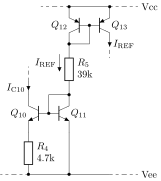

In [4]:
%%tikz -p circuitikz -s400,400 -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [npn, xscale=-1] (Q10) {\ctikzflipx{$Q_{10}$}};
\draw (Q10.E) to [R, l2={$R_4$ and 4.7k},bipoles/length=1.0cm] ++(0, -1.5)
  node [circ] {} coordinate (G);
\draw (Q10.B) node [npn, anchor=B] (Q11) {$Q_{11}$};
\draw (Q11.B) node [circ] {} |- (Q11.C) node [circ] {};
\draw (Q11.E) to [short, -*] (Q11.E |- G);

\draw (Q11.C) to [R, l2_={$R_5$ and 39k},bipoles/length=1.0cm] ++(0, 1.8)
  node [pnp, anchor=C, xscale=-1] (Q12) {\ctikzflipx{$Q_{12}$}};
\draw (Q12.B) node [pnp, anchor=B] (Q13) {$Q_{13}$};

\draw (Q12.B) node [circ] {} |- (Q12.C) node [circ] {};
\draw [dashed] (G) to [short] ++(-1, 0);
\draw (Q12.E) to [short, *-*] (Q13.E);
\draw [dashed] (Q13.E) to [short] ++(1, 0) node [right] {Vcc};
\draw [dashed] (Q12.E) to [short] ++(-1, 0);
\draw (Q10.C) to [short, i<={$I_\mathrm{C10}$}] ++(0, 0.5);
\draw [dashed] (Q10.C) ++(0, 0.5) to [short] ++(0, 0.5);
\draw (Q13.C) node [currarrow, rotate=-90] {} node [right] {$I_\mathrm{REF}$};
\draw [dashed] (Q13.C) to [short] ++(0, -0.5);
\draw (G) -- (G-|Q13.C);
\draw [dashed] (G-|Q13.C) to [short] ++(1, 0) node [right] {Vee};
\draw (Q12.C)++(-0.1, 0) to [open, f>_={$I_\mathrm{REF}$}] ++(0, -3);

The current on $R_5$ is the reference current, and it's set by power supply voltage, $\uv{CC}=15$V, $\uv{EE}=-15$V.
Assuming $\uv{BE} = 0.65$V for Q11 and Q12.

$\ui{REF}=\ui{R5}=\dfrac{\uv{CC}-\uv{EE}-2\uv{BE}}{R_5} = \dfrac{30-2\times 0.65}{39\mathrm{k}} = 0.736\mA$

Let's verify, $\uv{BE}=\Vt\ln\dfrac{\ui{E}}{\Is} = \Vt \ln\dfrac{0.736\times10^{-3}}{10^{-14}} =  645.6$ mV, matches the estimation of 0.65V above.

In [3]:
Vt = 25.8
Vbe = Vt * log(0.736e-3 / 1e-14)
print('Vbe @ Ic=0.736mA = %.1f mV' % Vbe)

Vbe @ Ic=0.736mA = 645.6 mV


Let's calculate $I_\mathrm{C10}$, which is the bias current of the input stage.

Q10/Q11 and R4 form a Wildar current source.

$I_\mathrm{C10} R_4 = V_\mathrm{T}\ln \dfrac{I_\mathrm{REF}}{I_\mathrm{C10}}$

It's a transcendental equation, let's solve $\ui{C10}$ using numerical method, which gives 19.84µA.

In [12]:
def Ic10(x):
    Ic = x
    Vt = 25.8
    Iref = 736
    R4 = 4.7
    return Ic * R4 - Vt * np.log(Iref / Ic)

# Trial and error
if False:
    print(Ic10(10))
    print(Ic10(20))
    print(Ic10(19))
    print(Ic10(19.5))
    print(Ic10(19.8))

root = scipy.optimize.root_scalar(Ic10, x0=0.1)
if root.converged:
    Ic = root.root
    print('Ic10 = %.2f uA' % (Ic))

Ic10 = 19.84 uA


### Input stage

Given $\beta \gg 1$, ignoring base currents and assuming $\ui{E}\approx\ui{C}$.
Due to the current mirror made of Q5/Q6, we shall have $\ui{C1} = \ui{C2} = \ui{C3} = \ui{C4} = \ui{C5} = \ui{C6}$.

Let's show that $\ui{C8}=\ui{C9}=\ui{C10}$, the input stage is redrawn below, with Q1/Q2/D1/D2 being considered as short-circuit wires in this analysis.

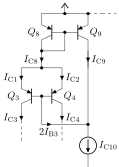

In [5]:
%%tikz -p circuitikz -s 400,400 -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [pnp, xscale=-1] (Q8) {\ctikzflipx{$Q_8$}};
\draw (Q8.B) to [short] ++(0.2, 0)
  node [pnp, anchor=B] (Q9) {$Q_9$};
\draw (Q8.B) ++(0.1, 0) coordinate (M) node [circ] {} |- (Q8.C);
\draw (Q8.E) to [short, -*] (Q9.E);
\draw [dashed] (Q9.E) to [short] ++(1, 0);
\draw (Q8.E -| M) node [circ] {} node [vcc] {};

\draw (Q8.C) to [short, *-*, i_={$I_\mathrm{C8}$}] ++(0, -0.6) coordinate (T);
\draw (T) ++(0, -1)  node [pnp, anchor=B, xscale=-1] (Q3) {\ctikzflipx{$Q_3$}};
\draw (Q3.B) node [pnp, anchor=B] (Q4) {$Q_4$};
\draw (Q3.E) |- (T) -| (Q4.E);
\draw (Q3.E) node [currarrow, rotate=-90] {} node [left] {$I_\mathrm{C1}$};
\draw (Q4.E) node [currarrow, rotate=-90] {} node [right] {$I_\mathrm{C2}$};

\draw (Q3.B) to [short, *-] ++(0, -1) coordinate (B)
  to [short, i_={$2I_\mathrm{B3}$}] ++(0.5, 0)
  to [short, -*] (B-|Q9.C) coordinate (C)
  to [I, bipoles/length=1.0cm, l={$I_\mathrm{C10}$}] ++(0, -1.5);
\draw (C) -- (Q9.C);
\draw (Q9.C) to [short, i={$I_\mathrm{C9}$}] (Q9.C|-T);
\draw (Q3.C) to [short, i_={$I_\mathrm{C3}$}] ++(0, -0.2);
\draw [dashed] (Q3.C)  ++(0, -0.2) to [short] ++(0, -0.8);
\draw (Q4.C) to [short, i={$I_\mathrm{C4}$}] ++(0, -0.2);
\draw [dashed] (Q4.C)  ++(0, -0.2) to [short] ++(0, -0.8);

The input stage bias can be viewed as a Wilson current source (shown below), the input (reference) current is $\ui{C10}$, the output current is $\ui{C3} + \ui{C4}= \ui{C1} + \ui{C2} = \ui{C8}$. Clearly $\ui{C1} = \ui{C2} = \dfrac{\ui{C10}}{2} = 9.9\uA$

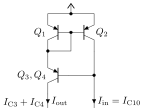

In [6]:
%%tikz -p circuitikz -s 400,240 -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [pnp, xscale=-1] (Q1) {\ctikzflipx{$Q_1$}};
\draw (Q1.B) to [short] ++(0.2, 0)
  node [pnp, anchor=B] (Q2) {$Q_2$};
\draw (Q1.B) ++(0.1, 0) coordinate (B) node [circ] {} |- (Q1.C);
\draw (Q1.C) to [short, *-] ++(0, -0.2)
  node [pnp, anchor=E, xscale=-1] (Q3) {\ctikzflipx{$Q_3, Q_4$}};
\draw (Q3.B) to [short, -*] (Q3.B-|Q2.C);
\draw (Q1.E) -- (Q2.E);
\draw (Q1.E -| B) node [circ] {} node [vcc] {};
\draw (Q2.C) to [short] (Q2.C|-Q3.C);
\draw (Q2.C|-Q3.C) to [short, i={$I_\mathrm{in}=I_\mathrm{C10}$}] ++(0, -0.5);
\draw (Q3.C) to [short, i={$I_\mathrm{out}$}] ++(0, -0.5)
++(0, 0.2) node [left] {$I_\mathrm{C3} + I_\mathrm{C4}$};

Let's calculate Q7, as shown below.

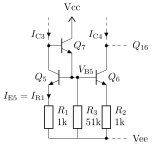

In [7]:
%%tikz -p circuitikz -s 400,300 -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0, 0) node [npn, xscale=-1] (Q5) {\ctikzflipx{$Q_5$}};
\draw (Q5.B) to [short, -*] ++(0.3, 0) coordinate (M);
\draw (M) to [short] ++(0.3, 0) node [npn, anchor=B] (Q6) {$Q_6$};
\draw (Q5.E) to [R, l2={$R_1$ and 1k},bipoles/length=1.0cm] ++(0, -1.5)
  coordinate (G);
\draw (Q6.E) to [R, l2={$R_2$ and 1k},bipoles/length=1.0cm] ++(0, -1.5)
  node [circ] {} --(G);
\draw (M|-G)  to [R, l2_={$R_3$ and 51k},bipoles/length=1.0cm] ++(0, 1.5) -- (M);
\draw [dashed] (G-|Q6.E) to [short] ++(0.8, 0) node [right] {Vee};

\draw (Q5.C-|Q5.B) ++(0.1, -0.2)  node [npn, anchor=E] (Q7) {$Q_7$};
\draw (Q7.C) node [vcc] {Vcc};
\draw (Q7.E) to [short, -*] (Q7.E|-Q5.B);
\draw (Q7.B) to [short, -*] (Q7.B-|Q5.C) -- (Q5.C);
\draw [dashed] (Q7.B-|Q5.C) to [short] ++(0, 1);
\draw (Q7.B-|Q5.C)++(0, 0.4) node [currarrow, rotate=-90] {}
  node [left] {$I_\mathrm{C3}$};
\draw (Q6.C) to [short, -*] (Q6.C|-Q7.B);
\draw [dashed] (Q7.B-|Q6.C) to [short] ++(0, 1);
\draw (Q7.B-|Q6.C)++(0, 0.4) node [currarrow, rotate=-90] {}
  node [left] {$I_\mathrm{C4}$};

\draw [dashed] (Q6.C|-Q7.B) to [short] ++(0.8, 0) node [right] {$Q_{16}$};
\draw (Q6.B) node [above] {$V_\mathrm{B5}$};
\draw (Q5.E) node [currarrow, rotate=-90] {} node [left] {$I_\mathrm{E5}=I_\mathrm{R1}$};

Ignoring base currents of Q5/Q6. $\ui{E7}\approx\ui{R3}$

* $\uv{B5}-\uv{EE}= \ui{R3}\,R_3 = \uv{BE5} + \ui{R1}\,R_1$

* $\uv{BE5} = \Vt\ln\dfrac{\ui{E5}}{\Is}\approx 25.8\times\ln\dfrac{9.9\times 10^{-6}}{10^{-14}} =534.4$mV

*  $\ui{E7}\approx\ui{R3}=\dfrac{\uv{BE5} + \ui{R1}\,R_1}{R_3} = \dfrac{534.4 + 9.9}{51\mathrm{k}} = 10.67$µA.


IIUC, Q7 helps stabilize the current mirror Q5/Q6 and reduce offset:

* Its Ic is set to the same as Q16, because R3 = R12 = 50k, so its base draws the same amount of current from Q3.C as Q16's base draws from Q4.C, therefore reduces offset caused by output to Q16.
* It provides base currents for Q5/Q6, so its base draws much less current from Q3 collector ($\ui{B7} = \dfrac{\ui{E7}}{\beta+1} = \dfrac{\ui{B5}+\ui{B6} + \ui{R3}}{\beta+1}$) comparing to basic current mirror circuit (replacing Q7 with wire of its BE junction, $\ui{B5}+\ui{B6}$ would be directly drawn from Q3 collector). This also helps reduces offset caused by different bias currents of Q1/Q3 and Q2/Q4.
* It sets $\uv{C5}$ to be 2Vbe above Vee, same as $\uv{C6}$ ($=\uv{BE16} + \uv{BE17}$), so as to minimize offset caused by Early effects on Q5/Q6.

### Gain stage

Q16 and Q17 form a Darlinton pair, which provides most (if not all) of voltage gain.

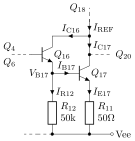

In [8]:
%%tikz -p circuitikz -s 400,300 -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end,bipoles/length=1.2cm}

\draw (0,0) node [npn] (Q17) {$Q_{17}$};
\draw (Q17.B) to [short, -*] ++(-0.6, 0) node [left] {$V_\mathrm{B17}$}
  node [npn, anchor=E] (Q16) {$Q_{16}$};
\draw (Q16.C) to [short, -*, i<={$I_\mathrm{C16}$}] (Q16.C-|Q17.C) coordinate (Q17c)
  to [short, -*, i={$I_\mathrm{C17}$}] (Q17.C);

%\draw (Q18.E) ++(0, -0.2) node [currarrow, rotate=-90] {}
%  node [left] {$\sim I_\mathrm{REF}$};
\draw (Q17c) to [short, i_<={$I_\mathrm{REF}$}] ++(0, 0.6);
\draw [dashed] (Q17c) ++(0, 0.5) to [short] ++(0, 0.5) node [left] {$Q_{18}$};
\draw [dashed] (Q17.C) to [short] ++(0.8, 0) node [right] {$Q_{20}$};
\draw [dashed] (Q16.B) to [short] ++(-0.8, 0) node [above] {$Q_4$} node [below] {$Q_6$};
\draw (Q17.E) node [currarrow, rotate=-90] {}
  node [right] {$I_\mathrm{E17}$}
  to [R, l2={$R_{11}$ and 50$\Omega$},bipoles/length=1.0cm] ++(0, -1.5) coordinate (G);
\draw (G) to [short, *-o] ++(0.8, 0) coordinate (VEE) node [right] {Vee};

\draw (G) to [short, -*] (G-|Q16.E)
  to [R, l2_={$R_{12}$ and 50k},bipoles/length=1.0cm] (Q16.E |- Q17.E)
  node [currarrow, rotate=-90] {}
  node [right] {$I_\mathrm{R12}$} -- (Q16.E);
\draw [dashed] (G-|Q16.E) to [short] ++(-1.0, 0);
\draw (Q17.B) ++(-0.1, 0) node [currarrow] {} node [above] {$I_\mathrm{B17}$};

Ignoring base currents for Q16/Q14/Q20, according to KCL: $\ui{REF} = \ui{R12}+\ui{E17} = 0.736$mA.

According to KVL: $\uv{B17}-\uv{EE} = \ui{R12}\,R_{12} = \uv{BE17} + \ui{E17}\,R_{11}$.

Solving the linear equations, assuming $\uv{BE17} = 0.65$V:

$\ui{R12}+\ui{E17} = 0.736\times 10^{-3}$

$\ui{R12}\,R_{12} = 0.65 + \ui{E17}\,R_{11}$

We got $\ui{R12}=13.7$µA and $\ui{E17} = 722.3$µA.

$\ui{E16}=\ui{R12}+\ui{B17}=\ui{R12}+\dfrac{\ui{E17}}{\beta+1}=18.2$µA.

### Output stage

Q18 is a Vbe multiplier, 
$\uv{CE18} = \Big(1+\dfrac{R_7}{R_8}\Big)\uv{BE18} = 1.63\times 0.65 = 1.057$V.

Ignoring the voltages on R9 and R10, when output voltage is 0V, we assume that $\uv{BE14}$ and $\uv{BE20}$ bisects $\uv{CE18}$, i.e. $\uv{BE14} = \uv{BE20} = \uv{CE18} / 2 = 0.528$V

$ \ui{E14}=\ui{E20}=\Is\exp\dfrac{\uv{BE14}}{\Vt}=10^{-14}\exp\dfrac{0.528}{0.0258} = 7.7$µA.

The bias current of output stage is probably smaller than IC, as the area of Q14/Q20 is not enlarged in discrete circuits.

### Summary

We have calculated bias currents of all 18 active transistors by hand.

| Transistors | $\ui{C}$ (µA) | Simulation (µA) |
| --- | --- | --- |
| Q11/Q12 | $\ui{REF}=736$ | 736 |
| Q13 | 736 | 927 |
| Q10/Q9 | $\ui{C10}=19.84$ | 20.33 |
| Q8 | 19.84 | 15.6 |
| Q1/Q2/Q3/Q4/Q5/Q6 | 9.9 | ~7.8 |
| Q7 | 10.67 | 10.6 |
| Q16 | 18.2 | 18.5 |
| Q17 | 722.3 | 908.5 |
| Q18 | ?? | 835 |
| Q14/Q20 | 7.7 | ~14.6 |
| Q15/Q22 | 0 | 0 |

The errors are probably due to limited $\uv{A}$.
For example, consider current mirror Q12/Q13, $\uv{BE12} = \uv{BE13}$, but
$\uv{CE12}\approx -0.65$V, $\uv{CE13}\approx -14.45$V, so $\ui{C13} \approx \ui{C12}\Big(1+\dfrac{|\uv{CE13}|}{\uv{A}} \Big) \Big/\Big(1+\dfrac{|\uv{CE12}|}{\uv{A}} \Big) = 736\times\dfrac{50+14.45}{50+0.65} = 936.5$µA.

Similar cases in Q8/Q9.

## Simulation

The simulation ideas were from [Chapter 10](https://www.ece.mcgill.ca/~grober4/SPICE/SPICE_Decks/1st_Edition/chapter10/Chapter%2010%20%20Analog%20Integrated%20Circuits%20web%20version.html) of [_SPICE for Microelectronic Circuits_](https://www.ece.mcgill.ca/~grober4/SPICE/SPICE_Decks/spicedecks_ed1_index.html) by Gordon W. Roberts and Adel S. Sedra. I have possession of a physical copy of the second edition.

The simulation is done using NgSpice from Python Jupyter, following:

* http://blog.chenshuo.com/2024/02/ngspice-python-jupyter.html
* https://github.com/chenshuo/notes/blob/master/notebooks/AnalogCircuits.ipynb

Netlist of 20T and 24T µA741, and discrete XL741: https://github.com/chenshuo/notes/blob/master/notebooks/ua741.cir


### Input offset and open loop gain

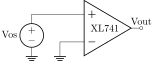

In [9]:
%%tikz -p circuitikz -f svg

\ctikzset{baseline, american currents, american voltages, european resistors}

\draw (0, 0) node [op amp, noinv input up] (OA) {XL741};

\draw (OA.+) to [short] ++(-1.5, 0)
  to [V, l_={Vos}] ++(0, -1.5) coordinate (G)
       node [tlground] {};
\draw (OA.-) to [short] ++(-0.5, 0) coordinate (INV)
  to [short] (INV|-G) node [tlground] {};
\draw (OA.out) node [ocirc] {} node [above] {Vout};

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


Output range: -13.38 V to 14.26 V


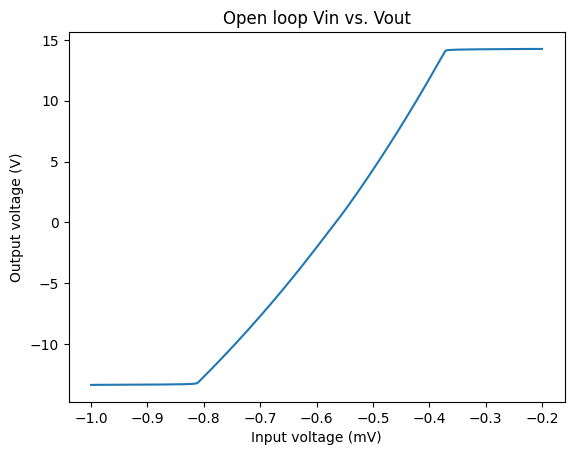

In [11]:
ng.circ('''
* Power and input

Vcc vcc 0  15V
Vee vee 0 -15V

Vin vin 0   DC 0 AC 1
Rd1 vin in+ 1
Rd2 in- 0   1

Rload out    0   10k

X in+ in- out vcc vee XL741

.include ua741.cir

* .options savecurrents
''')

ng.cmd('dc vin -1m -200u 0.1u')

Vout = ng.vector('out')
Vin = ng.vector('in+')
plt.plot(Vin * 1e3, Vout)
plt.xlabel('Input voltage (mV)')
plt.ylabel('Output voltage (V)')
plt.title('Open loop Vin vs. Vout')
print('Output range: %.2f V to %.2f V' % (min(Vout), max(Vout)))

In [27]:
cross_point = np.sum(Vout < 0)
assert Vout[cross_point] > 0 and Vout[cross_point-1] < 0
print('Vos = %.1f uV' % (Vin[cross_point] * 1e6))

assert Vout[0] < -10 and Vout[-1] > 10
start = np.sum(Vout < -10)
end =  np.sum(Vout < 10)
deltaVin = Vin[end] - Vin[start]
print('Delta Vin for 10V delta in Vout: %.1f uV' % (1e6*deltaVin/2))
deltaVout = Vout[end] - Vout[start]
gain = deltaVout / deltaVin
print('Gain = %.0f, %.1f dB' % (gain, 20*log10(gain)))

Vos = -565.7 uV
Delta Vin for 10V delta in Vout: 160.7 uV
Gain = 62248, 95.9 dB


Set the input voltage to offset voltage and print the operating point.

In [8]:
ng.cmd('alter vin DC -565.7u')
print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


@c.x.c1[i] =     0.00 nanoA
@d.x.d1[id] =     7.84 uA
@d.x.d2[id] =     7.90 uA
  @q10[ib] =   112.12 nanoA
  @q10[ic] =    20.33 uA
  @q11[ib] =     4.57 uA
  @q11[ic] =   731.36 uA
  @q12[ib] =    -4.54 uA
  @q12[ic] =  -726.96 uA
  @q13[ib] =    -4.54 uA
  @q13[ic] =  -926.99 uA
  @q14[ib] =    80.46 nanoA
  @q14[ic] =    14.74 uA
  @q15[ib] =    -0.00 nanoA
  @q15[ic] =     0.00 nanoA
  @q16[ib] =   102.32 nanoA
  @q16[ic] =    18.54 uA
  @q17[ib] =     4.99 uA
  @q17[ic] =   908.45 uA
  @q18[ib] =     5.20 uA
  @q18[ic] =   834.98 uA
   @q1[ib] =    42.54 nanoA
   @q1[ic] =     7.79 uA
  @q20[ib] =   -70.08 nanoA
  @q20[ic] =   -14.46 uA
  @q22[ib] =    -0.00 nanoA
  @q22[ic] =     0.00 nanoA
   @q2[ib] =    42.88 nanoA
   @q2[ic] =     7.85 uA
   @q3[ib] =   -38.74 nanoA
   @q3[ic] =    -7.80 uA
   @q4[ib] =   -39.16 nanoA
   @q4[ic] =    -7.86 uA
   @q5[ib] =    48.15 nanoA
   @q5[ic] =     7.75 uA
   @q6[ib] =    48.13 nanoA
   @q6[ic] =     7.76 uA
   @q7[ib] =    51.24 nanoA


Input bias current = $\dfrac{\ui{B1} + \ui{B2}}{2} =\dfrac{42.54+42.88}{2} = 42.7$nA.

### Transfer function

In [12]:
ng.cmd('alter vin DC -565.7u')
ng.cmd('tf v(out) vin')
ng.vectors()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


{'output_impedance_at_V(out)': array([933.32532472]),
 'vin#Input_impedance': array([3072717.24070592]),
 'Transfer_function': array([58878.17650299])}

### Frequency response

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


Gain at DC 58875.49598797573


Text(0, 0.5, 'Phase (degree)')

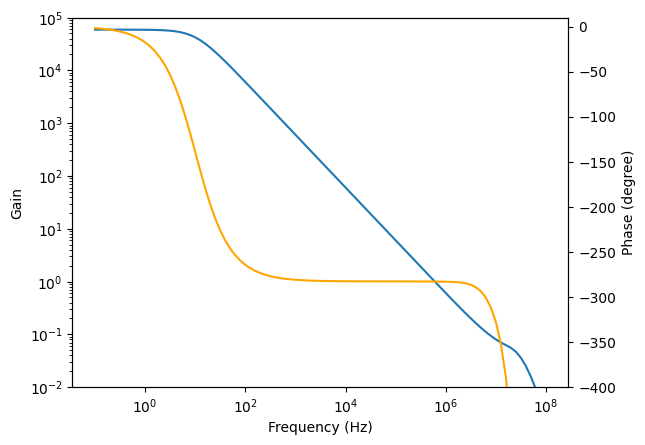

In [24]:
ng.cmd('AC dec 10 0.1Hz 100MegHz')
freq = ng.vector('frequency')
out = ng.vector('out')
fig, ax = plt.subplots()
plt.loglog(freq, np.abs(out))
plt.ylabel('Gain')
plt.xlabel('Frequency (Hz)')
print('Gain at DC', np.abs(out[0]))
plt.ylim(1e-2, 1e5)
ax2 = ax.twinx()
plt.semilogx(freq, np.unwrap(np.angle(out))*180, 'orange')
plt.ylim(-400, 10)
plt.ylabel('Phase (degree)')

Input common-mode range

Slew rate

Play with Q7 and R3

### Gain stage

Because of higher $\beta$ of discrete 2N3904, the Q16/Q17 Darlinton pair might not be needed, try changing Q16 to emitter follower like the 24T design?

### Output bias

Play with Q18, show crossover distortion

### Short-circuit protection

https://electronics.stackexchange.com/questions/483829/how-is-the-741-op-amp-output-protected-when-shorted-to-v

## Measure with multimeter

$\ui{REF}=729$μA